In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import opening, closing, disk

%matplotlib widget

In [29]:
def computeDepthMap(imgL, imgR, mask):
    
        # ------------------------------------- #
        # SETUP
        # ------------------------------------- #
        imgL = cv2.GaussianBlur(imgL, (5,5), 0)
        imgR = cv2.GaussianBlur(imgR, (5,5), 0)

        # read camera data
        data = cv2.FileStorage('stereo_params_v2.yml', cv2.FILE_STORAGE_READ)
        keys = ["K1", "K2", "D1", "D2", "R1", "R2", "P1", "P2", "T"]
        [K1, K2, D1, D2, R1, R2, P1, P2, T] = [data.getNode(key).mat() for key in keys]

        '''
        We know that

                |f  0   cx1  0|
        P1 =    |0  f   cy   0|
                |0  f   1    0|

        and 

                |f  0   cx2  Tx*f|
        P2 =    |0  f   cy   0   |
                |0  f   1    0   |

        and in our case, cx1 = cx2 = cx
        '''

        f = K1[0,0]
        Tx = T[0,0]
        P1 = np.hstack((K1, np.array([[0],[0],[0]])))
        P2 = np.hstack((K2, np.array([[Tx*f],[0],[0]])))


        # ------------------------------------- #
        # STEREO RECTIFICATION
        # ------------------------------------- #
        h1, w1 = imgL.shape

        # rectify images using initUndistortRectifyMap
        xmap1, ymap1 = cv2.initUndistortRectifyMap(K1, D1, R1, P1, (w1,h1), cv2.CV_32FC1)
        xmap2, ymap2 = cv2.initUndistortRectifyMap(K2, D2, R2, P2, (w1,h1), cv2.CV_32FC1)

        imgL_rectified = cv2.remap(imgL, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        imgR_rectified = cv2.remap(imgR, xmap2, ymap2, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        mask_rectified = cv2.remap(mask, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

        # -------------------------------- #
        # COMPUTE DISPARITY MAP
        # -------------------------------- #

        # Matched blocked size
        window_size = 11
        min_disp = 0
        num_disp = 128-min_disp
        stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
                numDisparities = num_disp,
                blockSize = window_size,
                uniquenessRatio = 10,
                speckleWindowSize = 100,
                speckleRange = 2,
                disp12MaxDiff = 5,
                P1 = 8*3*window_size**2,
                P2 = 32*3*window_size**2)
        
        right_matcher = cv2.ximgproc.createRightMatcher(stereo)

        # WLS Filter Parameters
        lmbda = 8000
        sigma=1.4
        visual_multiplier = 1.0

        wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
        wls_filter.setLambda(lmbda)
        wls_filter.setSigmaColor(sigma)

        # Compute the depth images
        disp = stereo.compute(imgL_rectified, imgR_rectified)
        dispL = disp
        dispR = right_matcher.compute(imgR_rectified, imgL_rectified)
        dispL = np.int16(dispL)
        dispR = np.int16(dispR)

        # Filtering with the WLS Filter
        filtered = wls_filter.filter(dispL, imgL_rectified, None, dispR)
        filtered = cv2.normalize(src=filtered, dst=filtered, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
        filtered = np.uint8(filtered)

        disp = ((disp.astype(np.float32) / 16) - min_disp) / num_disp
        kernel= np.ones((3,3),np.uint8)
        # apply morphological closing to remove little black holes (removing noise)
        closing = cv2.morphologyEx(disp, cv2.MORPH_CLOSE, kernel)
        disp_closed = (closing - closing.min()) * 255
        disp_closed = disp_closed.astype(np.uint8)

        return [disp_closed, filtered]


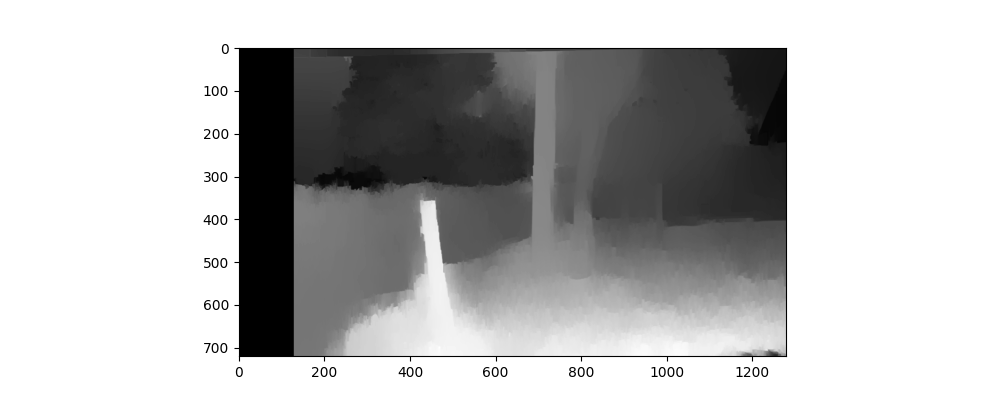

In [46]:
# ------------------------------------- #
# LOAD IMAGES
# ------------------------------------- #
imgL = cv2.imread('trunks/left_2.png', 0)
imgR = cv2.imread('trunks/right_2.png', 0)
mask = cv2.imread('full_trees/masks/mask_8.png', 0)

depth = computeDepthMap(imgL, imgR, mask)[1]

plt.close()
plt.figure(figsize=(10,4))
plt.imshow(depth, 'gray')
plt.show()